In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from data.motion_dataset import MotionDataset
from data.motion_sampler import MotionSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
train_dataset = MotionDataset('train', tokenizer_name='t5-small')
train_sampler = MotionSampler(train_dataset.motion_frames, batch_size=32, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)

In [55]:
description_length = []
for dico in train_dataset:
    text = dico['text']
    for line in text:
        description_length.append(len(line))

KeyboardInterrupt: 

Médiane : 56.0
90e percentile : 115.0
95e percentile : 141.0
Longueur max : 897


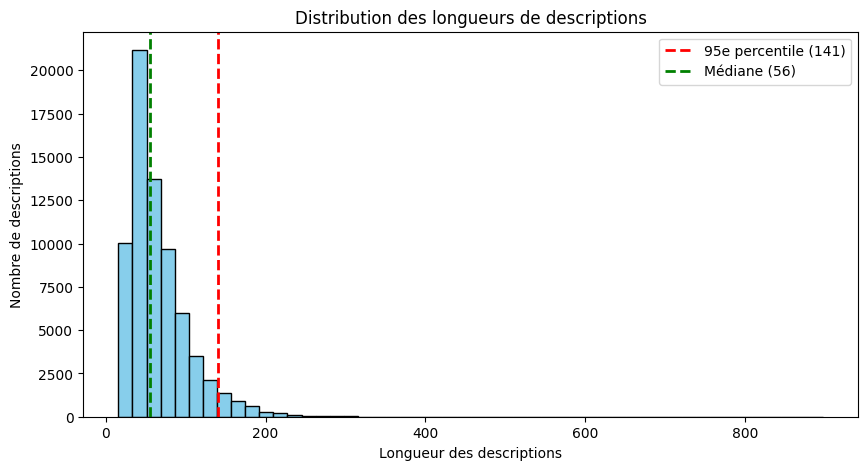

In [ ]:
# description_length = np.array(description_length)

median_len = np.median(description_length)
percentile_90 = np.percentile(description_length, 90)
percentile_95 = np.percentile(description_length, 95)
max_len = np.max(description_length)

print(f"Median: {median_len}")
print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")
print(f"Max length: {max_len}")

plt.figure(figsize=(10,5))
plt.hist(description_length, bins=50, color='skyblue', edgecolor='black')
plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=2, label=f'95th percentile ({int(percentile_95)})')
plt.axvline(median_len, color='green', linestyle='dashed', linewidth=2, label=f'Median ({int(median_len)})')
plt.xlabel('Description length')
plt.ylabel('Number of descriptions')
plt.title('Distribution of description lengths')
plt.legend()
plt.show()

In [15]:
from models.transformers.transfoLM import TransfoLM
from torchinfo import summary

tflm = TransfoLM(motion_dim=66, lm_name='t5-small')
summary(tflm, input_size=((32, 62, 22, 3), (32, 100)))  # (batch_size, seq_len, n_joints, 3), (batch_size, text_seq_len)

Layer (type:depth-idx)                                       Output Shape              Param #
TransfoLM                                                    [32, 99, 32128]           --
├─Linear: 1-1                                                [32, 62, 512]             34,304
├─PositionalEmbedding: 1-2                                   [32, 62, 512]             --
├─Dropout: 1-3                                               [32, 62, 512]             --
├─ModuleList: 1-4                                            --                        --
│    └─Encoder: 2-1                                          [32, 62, 512]             --
│    │    └─MultiHeadAttention: 3-1                          [32, 62, 512]             1,050,624
│    │    └─Dropout: 3-2                                     [32, 62, 512]             --
│    │    └─LayerNorm: 3-3                                   [32, 62, 512]             1,024
│    │    └─FeedForward: 3-4                                 [32, 62, 512]       